In [617]:
# building a model of a conditioned normal distribution

In [618]:
import jax.numpy as jnp
import jax
import optax

import numpy as np

import matplotlib.pyplot as plt

In [619]:
from time import sleep

In [620]:
from functools import partial

In [621]:
from tqdm.notebook import trange, tqdm

In [622]:
from typing import Dict

In [623]:
seed_fn = lambda : np.random.randint(0, 1e6)

In [624]:
seed_fn()

301848

In [625]:
input_units = 1
# units = 2
units = 20
# units = 200
output_units = 1

# initializer = jax.nn.initializers.normal(5.0)


initial_params = {
    'w1':jax.random.normal(shape=[input_units, units], key=jax.random.PRNGKey(seed_fn())),
    'w2':jax.random.normal(shape=[units, units], key=jax.random.PRNGKey(seed_fn())),
    'w3_mu':jax.random.normal(shape=[units, output_units], key=jax.random.PRNGKey(seed_fn())),
    'w3_var':jax.random.normal(shape=[units, output_units], key=jax.random.PRNGKey(seed_fn())),
    
    'b1':jax.random.normal(shape=[units,], key=jax.random.PRNGKey(seed_fn())),
    'b2':jax.random.normal(shape=[units,], key=jax.random.PRNGKey(seed_fn())),
    'b3_mu':jax.random.normal(shape=[output_units,], key=jax.random.PRNGKey(seed_fn())),
    'b3_var':jax.random.normal(shape=[output_units,], key=jax.random.PRNGKey(seed_fn())),
    # 'b3_var':initializer(jax.random.PRNGKey(seed_fn()), (output_units, ), jnp.float32),
}

In [626]:
def ann(x: jnp.ndarray, params: Dict) -> jnp.ndarray:
    """
    the output of the network will be the mean and standard deviation for a normal distribution
    """
    x = jnp.dot(x, params['w1']) + params['b1']
    x = jax.nn.sigmoid(x)
    # x = jax.nn.relu(x)
    x = jnp.dot(x, params['w2']) + params['b2']
    x = jax.nn.sigmoid(x)
    # x = jax.nn.relu(x)
    
    mu = jnp.dot(x, params['w3_mu']) + params['b3_mu']
    sd = jnp.dot(x, params['w3_var']) + params['b3_var']
    return mu, jax.nn.softplus(sd)

In [627]:
x = np.arange(0, 1, 0.01)[:,np.newaxis]
x_fine = np.arange(-0.1, 1.1, 0.001)[:,np.newaxis]
# x_fine = np.arange(0, 1., 0.001)[:,np.newaxis]

In [628]:
mu, sd = ann(x, initial_params)

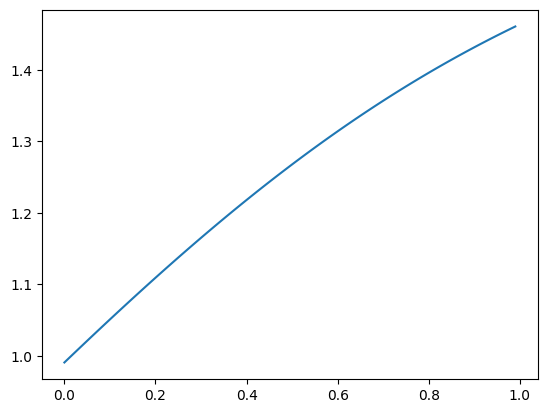

In [629]:
plt.plot(x, ann(x, initial_params)[0])

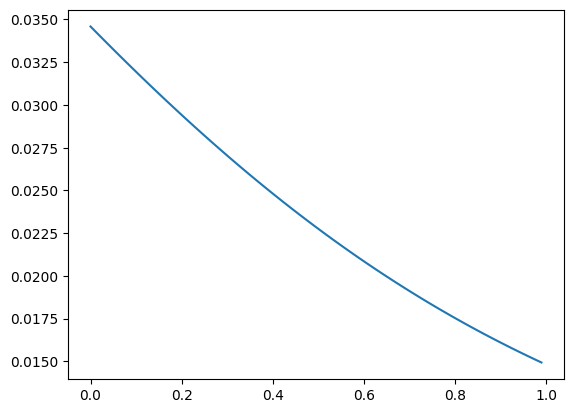

In [630]:
plt.plot(x, ann(x, initial_params)[1])

In [631]:
def gen_data():
    n_samples = 100
    # n_samples = 1000
    x = np.random.uniform(0, 1, n_samples)[:,np.newaxis]
    # y = x * np.sin(x/0.3)
    y = x * np.sin(x/0.1)

    y += np.random.normal(0, 0.02, (n_samples,1))
    
    # y[0] = 2
    
    mask = x < 0.2
    y[mask] += np.random.normal(0, 0.1, len(y[mask]))
    
    mask = (x > 0.5) & (x < 0.8)
    y[mask] += np.random.normal(0, 0.5, len(y[mask]))
    
    
    return x, y

In [632]:
X, y = gen_data()

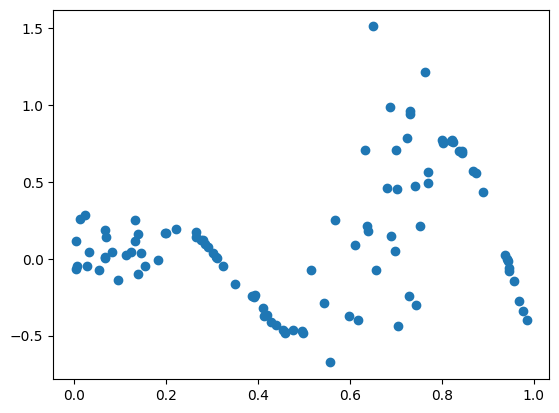

In [633]:
plt.plot(X, y, 'o')
# plt.plot(X, ann(X, initial_params), 'o')

In [634]:
# @partial(jax.jit, static_argnames=['model'])

# note here that we use the global model variable `ann`

def loss_fn(params, X, y):
    mu, sd = ann(X, params)
    
    log_prob = jax.scipy.stats.norm.logpdf(y, loc=mu, scale=sd)
    # loss_value = (y - yhat)**2
    # return loss_value.mean()
    # print(log_prob.shape)
    return -log_prob.mean()

In [635]:
loss_fn(initial_params, X, y)

Array(1643.954, dtype=float32)

In [636]:
def fit(params, optimizer):
    epochs = 100000
    # epochs = 10000
    # epochs = 1000
    every = epochs//100
    losses = []
    opt_state = optimizer.init(params)
    
    # @partial(jax.jit, static_argnames=['model'])
    # @partial(jax.jit, static_argnums=(0,))
    @jax.jit
    def step(params, opt_state, X, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, X, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    
    # https://stackoverflow.com/questions/37506645/can-i-add-message-to-the-tqdm-progressbar
    loop_obj = tqdm(np.arange(epochs))

    # for i in trange(100):
    for i in loop_obj:
        params, opt_state, loss_value = step(params, opt_state, X, y)
        losses.append(loss_value)
        if i % every == 0:
            loop_obj.set_description(f"Epoch: {i}")  # Adds text before progessbar
            loop_obj.set_postfix_str(f"Loss: {loss_value:,.3e}")  # Adds text after progressbar
        
    return params, np.array(losses)

In [637]:
optimizer = optax.adam(learning_rate=1e-3)
params, losses = fit(initial_params, optimizer)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [638]:
# params

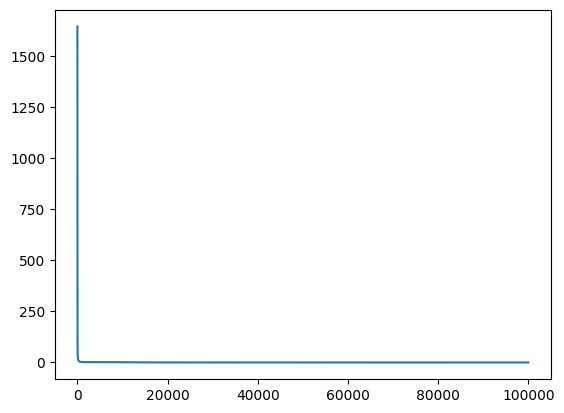

In [639]:
plt.plot(losses)

In [640]:
np.percentile(losses, 5)

-1.0785713255405427

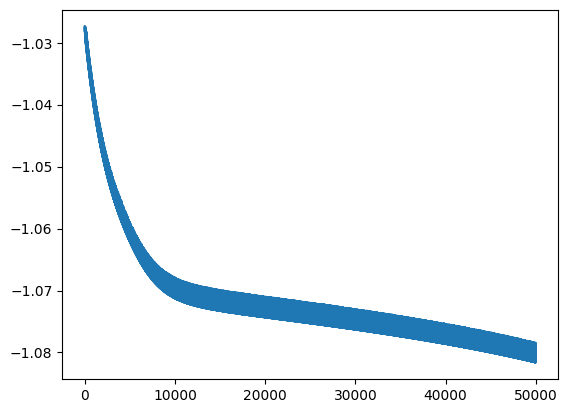

In [641]:
plt.plot(losses[losses < np.percentile(losses, 50)])

In [642]:
mu, sd = ann(x_fine, params)

Text(0.5, 1.0, 'uncertainty')

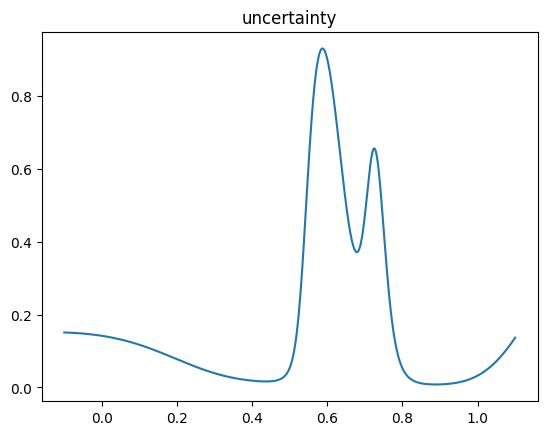

In [643]:
plt.plot(x_fine, sd)
plt.title('uncertainty')

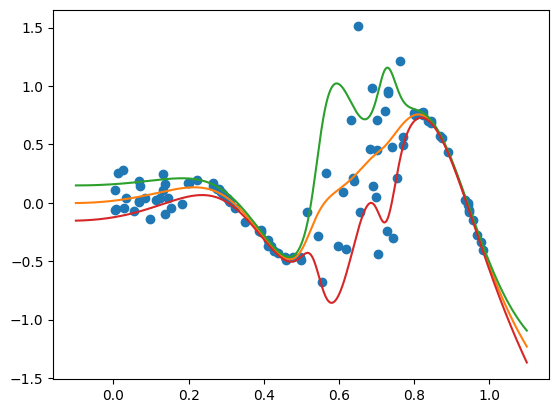

In [644]:
plt.plot(X, y, 'o')
plt.plot(x_fine, mu, '-')
plt.plot(x_fine, mu+sd, '-')
plt.plot(x_fine, mu-sd, '-')

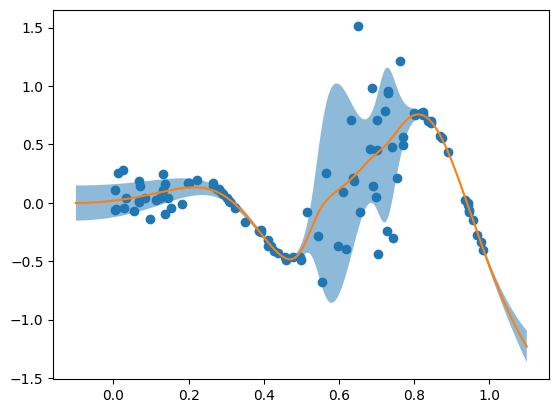

In [645]:
plt.plot(X, y, 'o')
plt.plot(x_fine, mu, '-')
plt.fill_between(x_fine[:,0], y1=(mu+sd)[:,0], y2=(mu-sd)[:,0], alpha=0.5)